#Resolviendo un Laberinto

El problema es muy sencillo: tenemos un laberinto, y deseamos que nuestro algoritmo genético encuentre la salida

Empecemos importando los paquetes necesarios y creando el laberinto:

In [ ]:
import random as random



#This function was taken from Eli Bendersky's website
#It returns an index of a list called "weights",
#where the content of each element in "weights" is the probability of this index to be returned.
#For this function to be as fast as possible we need to pass it a list of weights in descending order.
def weighted_choice_sub(weights):
    rnd = random.random() * sum(weights)
    for i, w in enumerate(weights):
        rnd -= w
        if rnd < 0:
            return i




generate_random_binary_list = lambda n: [random.randint(0,1) for b in range(1,n+1)]




class Individual (object):

    def __init__(self, genome):

        self.genome = genome
        self.traits = {}
        self.performances = {}
        self.fitness = 0



def generate_genome (dict_genes):

    #We first calculate the total number of bits that the genome must contain
    number_of_bits = sum([dict_genes[trait] for trait in dict_genes])

    #And we return a random genome of this length
    return generate_random_binary_list(number_of_bits)



def calculate_traits (individual, dict_genes):
    #This function must decipher the genome and return the traits of the individual.
    #Normally, the genome contains binary numerical values for the different traits.

    dict_traits = {}
    index = 0

    for trait in dict_genes:
        dict_traits[trait] = int(''.join(str(bit) for bit in individual.genome[index : index+dict_genes[trait]]), 2)
        index += dict_genes[trait]

    individual.traits = dict_traits




def immigration (society, target_population,
                 calculate_performances, calculate_fitness,
                 dict_genes, Object = Individual, *args):

    while len(society) < target_population:

        new_individual = Object (generate_genome (dict_genes), args)
        calculate_traits (new_individual, dict_genes)
        calculate_performances (new_individual)
        calculate_fitness (new_individual)

        society.append (new_individual)





def crossover (society, reproduction_rate, mutation_rate,
               calculate_performances, calculate_fitness,
               dict_genes, Object = Individual, *args):

    #First we create a list with the fitness values of every individual in the society
    fitness_list = [individual.fitness for individual in society]

    #We sort the individuals in the society in descending order of fitness.
    society_sorted = [x for (y, x) in sorted(zip(fitness_list, society), key=lambda x: x[0], reverse=True)]

    #We then create a list of relative probabilities in descending order,
    #so that the fittest individual in the society has N times more chances to reproduce than the least fit,
    #where N is the number of individuals in the society.
    probability = [i for i in reversed(range(1,len(society_sorted)+1))]

    #We create a list of weights with the probabilities of non-mutation and mutation
    mutation = [1 - mutation_rate, mutation_rate]

    #For every new individual to be created through reproduction:
    for i in range (int(len(society) * reproduction_rate)):

        #We select two parents randomly, using the list of probabilities in "probability".
        father, mother = society_sorted[weighted_choice_sub(probability)], society_sorted[weighted_choice_sub(probability)]

        #We randomly select two cutting points for the genome.
        a, b = random.randrange(0, len(father.genome)), random.randrange(0, len(father.genome))

        #And we create the genome of the child putting together the genome slices of the parents in the cutting points.
        child_genome = father.genome[0:min(a,b)]+mother.genome[min(a,b):max(a,b)]+father.genome[max(a,b):]

        #For every bit in the not-yet-born child, we generate a list containing
        #1's in the positions where the genome must mutate (i.e. the bit must switch its value)
        #and 0's in the positions where the genome must stay the same.
        n = [weighted_choice_sub(mutation) for ii in range(len(child_genome))]

        #This line switches the bits of the genome of the child that must mutate.
        mutant_child_genome = [abs(n[i] -  child_genome[i]) for i in range(len(child_genome))]

        #We finally append the newborn individual to the society
        newborn = Object(mutant_child_genome, args)
        calculate_traits (newborn, dict_genes)
        calculate_performances (newborn)
        calculate_fitness (newborn)
        society.append(newborn)



def tournament(society, target_population):

    while len(society) > target_population:

        #index1, index2 = random.randrange(0, len(society)), random.randrange(0, len(society))

        #if society[index1].fitness > society[index2].fitness:
        #    society.pop(index2)
        #else:
        #    society.pop(index1)

        fitness_list = [individual.fitness for individual in society]
        society.pop(fitness_list.index(min(fitness_list)))

import numpy as np
import matplotlib.pyplot as plt


#Primero vamos a definir los dos tipos de objeto que necesitamos:
class Map():
    def __init__(self, max_steps = 50, veneno = 0) :

        self.max_steps = max_steps
        self.veneno = veneno
        self.list_caminos = []
        self.history = []
        self.bestpath = None
        self.bestscore = -10E8
        self.dict_genes = {}
        for i in range (10):
            for j in range (10):
                self.dict_genes[i,j] = 2
        #------ -- Matrices del Mapa: ---------
        #Esta matriz describe las fronteras de cada casilla con cada número en binario:
        #primer dígito binario: frontera superior
        #segundo dígito binario: frontera derecha
        #tercer dígito binario: frontera inferior
        #cuarto dígito binario: frontera izquierda
        #Para cada dígito: 1 = frontera cerrada, 0 = frontera abierta
        self.grid = np.array([
                [9,  3,  9,  5,  5,  5,  5,  5,  5,  3 ],
                [10, 12, 6,  9,  1,  5,  5,  3,  9,  6 ],
                [10, 9,  3,  10, 10, 9,  3,  10, 10, 11],
                [10, 10, 10, 10, 10, 12, 6,  10, 8,  2 ],
                [8,  2,  8,  6,  12, 5,  5,  6,  10, 12],
                [10, 10, 12, 1,  5,  5,  1,  3,  12, 3 ],
                [10, 12, 3,  10, 9,  5,  6,  12, 3,  10],
                [8,  5,  6,  10, 10, 9,  3,  11, 10, 10],
                [10, 9,  3,  10, 12, 6,  12, 2,  10, 10],
                [12, 6,  12, 4,  5,  5,  5,  6,  12, 6 ]
            ])

        #Esta matriz simplemente es un damero que sirve para pintarlo bonito
        self.back = np.zeros([10,10])
        self.back[::2, ::2] = 1
        self.back[1::2, 1::2] = 1
        #En esta matriz guardaremos feromonas:
        self.feromap = np.zeros((10,10))

    def draw_tablero(self):
        '''Dibuja el laberinto'''
        plt.figure(1, figsize=(10,10))
        plt.matshow(self.back, fignum= 1, cmap=plt.cm.Oranges, alpha = 0.4)
        #plt.contourf(xx, yy, back, np.linspace(-1, 2, 3), cmap=plt.cm.Blues)
        plt.xlim(-1,10)
        plt.ylim(-1,10)
        x = list(range(10))
        y = x
        for i in x:
            for j in y:
                if self.grid[j,i] & 1 :
                    xx = i + np.array([-0.5,  0.5])
                    yy = j + np.array([-0.5,-0.5])
                    plt.plot(xx,yy, 'k', linewidth=3)
                if self.grid[j,i] & 2 :
                    xx = i + np.array([ 0.5, 0.5])
                    yy = j + np.array([-0.5, 0.5])
                    plt.plot(xx,yy, 'k', linewidth=3)
                if self.grid[j,i] & 4 :
                    xx = i + np.array([-0.5, 0.5])
                    yy = j + np.array([ 0.5, 0.5])
                    plt.plot(xx,yy, 'k', linewidth=3)
                if self.grid[j,i] & 8 :
                    xx = i + np.array([-0.5,-0.5])
                    yy = j + np.array([-0.5, 0.5])
                    plt.plot(xx,yy, 'k', linewidth=3)
        plt.gca().invert_yaxis()
    def create_camino(self):
        '''Crea un nuevo camino aleatorio'''
        self.list_caminos.append(Camino(False, [self]))

    def statistics(self):
        '''Analiza los valores de la puntuación de la población'''
        scores = []
        for j in self.list_caminos :
            scores.append(j.fitness)
            if j.fitness > self.bestscore:
                self.bestscore = j.fitness
                self.bestpath = j
        self.history.append([min(scores), sum(scores)/len(scores), max(scores)])

    def draw_history(self):
        '''Dibuja las gráficas de evolución de la puntuación'''
        plt.figure(None, figsize=(10, 8))
        history = np.array(self.history)
        for i in range(3):
            plt.plot(history[:, i])
        plt.title('Puntuación máxima, media y mínima para cada generación')

    def draw_best(self):
        '''Dibuja el mejor camino encontrado.
        Es necesario pintar el tablero por separado'''
        self.bestpath.draw_path(alpha = 0.5, c = 'b', w = 4)

    def draw_poison(self):
        '''Dibuja las toxinas o feromonas del mapa.
        Es necesario pintar el tablero por separado'''
        if self.veneno != 0:
            maxpoison = np.max(self.feromap)
            for i in range(10):
                for j in range(10):
                    poison = 0.8 * self.feromap[j,i] / maxpoison
                    plt.plot(i , j, 'o', color = 'g', alpha = poison, markersize=40)

    def reload_poison(self):
        '''Actualiza las feromonas y el valor de la aptitud de las soluciones'''
        self.bestpath = None
        self.bestscore = -10E8
        self.feromap /=2
        for i in self.list_caminos:
            i.deploy_poison()
        for i in self.list_caminos:
            calculate_fitness(i)


class Camino():
    '''Este objeto contiene una disposición dada de direcciones sobre el mapa,
    con la que se puede construir un camino'''
    def __init__(self, genome = False, opciones = False):
        self.poison = 0
        if not opciones:
            self.mapa = None
        else:
            self.mapa = opciones[0]
        self.dict_genes = {}
        for i in range (10):
            for j in range (10):
                self.dict_genes[i,j] = 2

        if not genome:
            self.genome = np.random.randint(0,2,200)
        else:
            self.genome = genome


    def draw_directions(self):
        '''Dibuja el tablero y a continuación, dibuja sobre él
        el mapa de direcciones'''
        self.mapa.draw_tablero()
        x = list(range(10))
        y = x
        for i in x:
            for j in y:

                if self.directions[j ,i] == 0:
                    plt.arrow(i, j + 0.4, 0, -0.6, head_width=0.1, head_length=0.2, fc='b', ec='b')
                if self.directions[j ,i] == 1:
                    plt.arrow(i - 0.4, j,  0.6, 0, head_width=0.1, head_length=0.2, fc='b', ec='b')
                if self.directions[j ,i] == 2:
                    plt.arrow(i, j - 0.4, 0,  0.6, head_width=0.1, head_length=0.2, fc='b', ec='b')
                if self.directions[j ,i] == 3:
                    plt.arrow(i + 0.4, j, -0.6, 0, head_width=0.1, head_length=0.2, fc='b', ec='b')

    #-- Funciones para calcular el camino

    def move(self, row, col, direction):
        '''Intenta moverse a la siguiente casilla'''
        grid = self.mapa.grid
        d = 2 ** direction

        if not grid[row, col] & d:

            if direction == 0:
                return row -1, col
            elif direction == 1:
                return row , col+1
            elif direction == 2:
                return row +1, col
            elif direction == 3:
                return row , col-1
        else:
            return None

    def step(self, row, col, direction, path):
        '''Intenta moverse a la siguiente casilla, si no lo consigue
        (porque choca con una pared), intenta moverse en otra dirección.
        Si la segunda vez tampoco lo consigue, se queda quieto.

        Devuelve información sobre si ha chocado o si ha vuelto a la casilla en la que estaba
        en el paso anterior'''
        wall = False
        u_turn = False
        newpos = self.move(row, col, direction)
        if newpos == None:
            wall = True
            new_d = np.random.randint(0,4)
            newpos = self.move(row, col, new_d)

        if newpos != None and  0<= col <=9:
            row,col = newpos
        if len(path) >=2 and [row, col] == path[-2]:
            u_turn = True
        return row, col, wall, u_turn

    def get_path(self):
        '''Calcula el camino a partir del mapa de direcciones'''

        max_steps = self.mapa.max_steps
        path = [[4,0]]
        wall_count = 0
        u_turn_count = 0
        for nstep in range(max_steps):
            #print('step:', nstep, end=' ')
            row, col = path[nstep]
            row, col, wall, u_turn = self.step(row, col, self.directions[row, col], path)
            wall_count += wall
            u_turn_count += u_turn
            path.append([row, col])
            if [row,col] == [4, 10]:
                break

        self.path, self.wall_count, self.u_turn_count = np.array(path), wall_count, u_turn_count
    def deploy_poison(self):
        '''Deposita feromonas negativas en las casillas que ha visitado'''
        if self.mapa.veneno != 0 :
            for i in range(self.path.shape[0]):
                row = self.path[i, 0]
                col = self.path[i, 1]
                if col < 10:
                    self.poison += self.mapa.feromap[row,col]
                    self.mapa.feromap[row,col] += 0.1 * self.mapa.veneno

    def draw_path(self, alpha = 0.5, c = 'r', w = 8):
        '''Dibuja su camino sobre el mapa.
        Es necesario pintar el tablero por separado'''
        plt.plot(self.path[:,1], self.path[:,0], c, linewidth = w, alpha = alpha)



def calculate_performances(individual):
    '''Calcula las performances de un individuo:
    En este caso, el camino a partir del mapa de direcciones.
    En este paso también se depositan las feromonas'''

    individual.directions = np.zeros([10,10], dtype=np.int)
    for i in range (10):
        for j in range (10):
            individual.directions[i,j] = individual.traits[(i,j)]
    individual.get_path()
    individual.deploy_poison()

def calculate_fitness(individual):
    '''Calcula la aptitud de un individuo'''
    path, wall_count, u_turn_count = individual.path, individual.wall_count, individual.u_turn_count
    poison = individual.poison
    max_steps = individual.mapa.max_steps
    endx = path[-1,1]
    victory = max_steps + 1 - len(path) # >0 si ha llegado al final, mayor cuanto más corto sea el camino
    individual.fitness = endx * 4 -  2 * wall_count - 3 * u_turn_count - 0.03 * poison + victory * 5

def avanzar(mapa, n = 100,
           max_pop = 100, min_pop = 10,
           reproduction_rate = 8, mutation_rate = 0.05):
    '''Efectua una cantidad n de generaciones '''
    for i in range(n):
        print(i+1, end='·')
        immigration(mapa.list_caminos, max_pop,
                   calculate_performances, calculate_fitness,
                   mapa.dict_genes, Camino, mapa)
        tournament(mapa.list_caminos, min_pop)
        mapa.reload_poison()
        crossover(mapa.list_caminos, reproduction_rate, mutation_rate,
                   calculate_performances, calculate_fitness,
                   mapa.dict_genes, Camino, mapa)
        mapa.statistics()

def draw_all(mapa):
    '''Dibuja el mapa con todas las soluciones de la generación actual,
    las feromonas del mapa, y gráficas de evolución.'''
    mapa.bestpath.draw_directions()
    mapa.draw_poison()
    for x in mapa.list_caminos:
        x.draw_path(0.1)

    mapa.draw_best()
    mapa.draw_history()

In [ ]:
import random as random



#This function was taken from Eli Bendersky's website
#It returns an index of a list called "weights",
#where the content of each element in "weights" is the probability of this index to be returned.
#For this function to be as fast as possible we need to pass it a list of weights in descending order.
def weighted_choice_sub(weights):
    rnd = random.random() * sum(weights)
    for i, w in enumerate(weights):
        rnd -= w
        if rnd < 0:
            return i



generate_random_binary_list = lambda n: [random.randint(0,1) for b in range(1,n+1)]




class Individual (object):

    def __init__(self, genome):

        self.genome = genome
        self.traits = {}
        self.performances = {}
        self.fitness = 0



def generate_genome (dict_genes):

    #We first calculate the total number of bits that the genome must contain
    number_of_bits = sum([dict_genes[trait] for trait in dict_genes])

    #And we return a random genome of this length
    return generate_random_binary_list(number_of_bits)



def calculate_traits (individual, dict_genes):
    #This function must decipher the genome and return the traits of the individual.
    #Normally, the genome contains binary numerical values for the different traits.

    dict_traits = {}
    index = 0

    for trait in dict_genes:
        dict_traits[trait] = int(''.join(str(bit) for bit in individual.genome[index : index+dict_genes[trait]]), 2)
        index += dict_genes[trait]

    individual.traits = dict_traits




def immigration (society, target_population,
                 calculate_performances, calculate_fitness,
                 dict_genes, Object = Individual, *args):

    while len(society) < target_population:

        new_individual = Object (generate_genome (dict_genes), args)
        calculate_traits (new_individual, dict_genes)
        calculate_performances (new_individual)
        calculate_fitness (new_individual)

        society.append (new_individual)





def crossover (society, reproduction_rate, mutation_rate,
               calculate_performances, calculate_fitness,
               dict_genes, Object = Individual, *args):

    #First we create a list with the fitness values of every individual in the society
    fitness_list = [individual.fitness for individual in society]

    #We sort the individuals in the society in descending order of fitness.
    society_sorted = [x for (y, x) in sorted(zip(fitness_list, society), key=lambda x: x[0], reverse=True)]

    #We then create a list of relative probabilities in descending order,
    #so that the fittest individual in the society has N times more chances to reproduce than the least fit,
    #where N is the number of individuals in the society.
    probability = [i for i in reversed(range(1,len(society_sorted)+1))]

    #We create a list of weights with the probabilities of non-mutation and mutation
    mutation = [1 - mutation_rate, mutation_rate]

    #For every new individual to be created through reproduction:
    for i in range (int(len(society) * reproduction_rate)):

        #We select two parents randomly, using the list of probabilities in "probability".
        father, mother = society_sorted[weighted_choice_sub(probability)], society_sorted[weighted_choice_sub(probability)]

        #We randomly select two cutting points for the genome.
        a, b = random.randrange(0, len(father.genome)), random.randrange(0, len(father.genome))

        #And we create the genome of the child putting together the genome slices of the parents in the cutting points.
        child_genome = father.genome[0:min(a,b)]+mother.genome[min(a,b):max(a,b)]+father.genome[max(a,b):]

        #For every bit in the not-yet-born child, we generate a list containing
        #1's in the positions where the genome must mutate (i.e. the bit must switch its value)
        #and 0's in the positions where the genome must stay the same.
        n = [weighted_choice_sub(mutation) for ii in range(len(child_genome))]

        #This line switches the bits of the genome of the child that must mutate.
        mutant_child_genome = [abs(n[i] -  child_genome[i]) for i in range(len(child_genome))]

        #We finally append the newborn individual to the society
        newborn = Object(mutant_child_genome, args)
        calculate_traits (newborn, dict_genes)
        calculate_performances (newborn)
        calculate_fitness (newborn)
        society.append(newborn)



def tournament(society, target_population):

    while len(society) > target_population:

        #index1, index2 = random.randrange(0, len(society)), random.randrange(0, len(society))

        #if society[index1].fitness > society[index2].fitness:
        #    society.pop(index2)
        #else:
        #    society.pop(index1)

        fitness_list = [individual.fitness for individual in society]
        society.pop(fitness_list.index(min(fitness_list)))

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
mapa1 = Map()

Pintemos el laberinto!

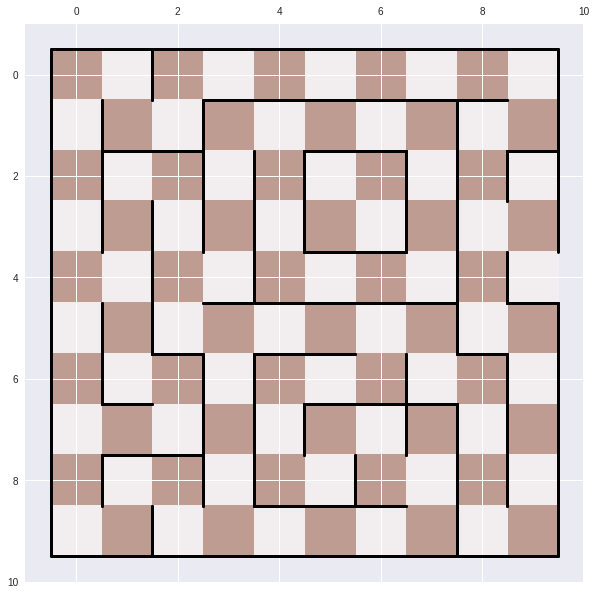

In [ ]:
mapa1.draw_tablero()

Queda chulo, ¿verdad?

## Creando un camino a partir de un genoma

Ahora viene una cuestión interesante: ¿Cómo definimos un camino a partir de un genoma?

Existen varias maneras, pero probablemente la mas simple sea esta:

Para cada casilla, el genoma nos designa una dirección, en la que un viajero intentaría moverse una vez que ha llegado a esa casilla.

Veamos cómo quedaría:

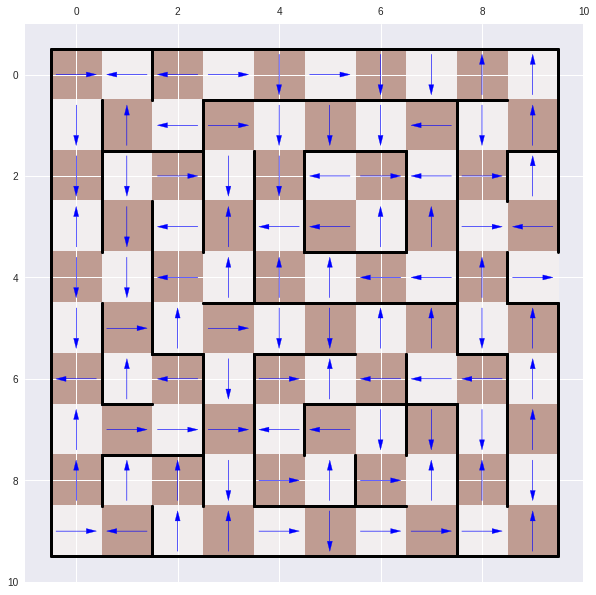

In [ ]:
mapa1.create_camino()
ejemplo = mapa1.list_caminos[0]
calculate_traits(ejemplo, ejemplo.dict_genes)
calculate_performances(ejemplo)
ejemplo.draw_directions()

Un viajero que intentara seguir estas indicaciones, estaría en un buen apuro. ¡Incluso algunas flechas apuntan a las paredes! Necesitaremos ser un poco flexibles para recorrerlo:


- Si la dirección de la casilla le dice que intente atravesar una pared, el viajero intentará otra dirección aleatoria.

- El viajero tendrá una cantidad limitada de pasos.

Probémoslo!

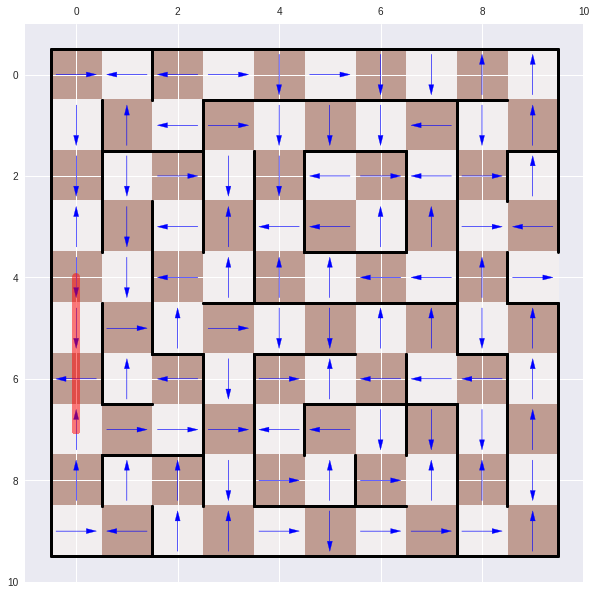

In [ ]:
ejemplo.draw_directions()
ejemplo.draw_path()

##Implementando el algoritmo genético

...La verdad es que como camino, no es gran cosa...

Pero no es suficiente con decir que es "malo", tenemos que ir más allá: tenemos que evaluar el camino objetivamente con una serie de reglas para poder usar el algoritmo genético:

- Cuando el viajero choque con una pared, el camino recibirá una pequeña penalización.

- Si hay dos casillas que se apuntan mutuamente, el viajero quedará atrapado, por lo que también penalizamos volver a la casilla de la que se partió en el turno anterior.

- Queremos llegar a la salida de la derecha, por lo que beneficiaremos a los caminos que dejen al viajero más a la derecha.

- Si un camino conduce a la salida, le daremos una gran bonificación para no perderlo

¡Probemos con estas reglas un algoritmo genético!

In [ ]:
calculate_fitness(ejemplo)
ejemplo.fitness

-143.0

Ya tenemos un valor numérico, lancemos el algoritmo!

1·2·3·4·5·6·7·8·9·10·11·12·13·14·15·16·17·18·19·20·21·22·23·24·25·26·27·28·29·30·31·32·33·34·35·36·37·38·39·40·41·42·43·44·45·46·47·48·49·50·51·52·53·54·55·56·57·58·59·60·61·62·63·64·65·66·67·68·69·70·71·72·73·74·75·76·77·78·79·80·81·82·83·84·85·86·87·88·89·90·91·92·93·94·95·96·97·98·99·100·

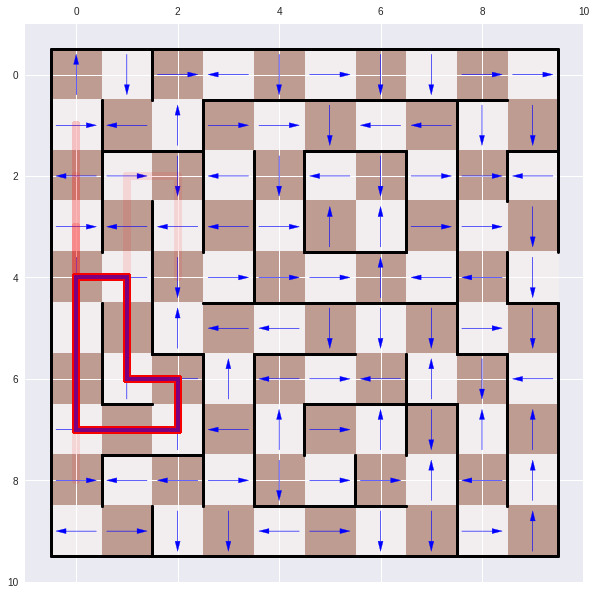

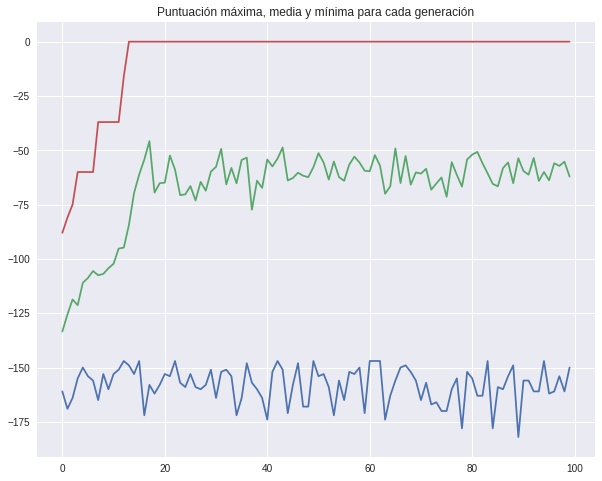

In [ ]:
avanzar(mapa1)
draw_all(mapa1)

La raya roja representa la puntuación maxima , la verde representa la puntuación media y la azul la mínima. A diferencia de los graficos siguientes, la nota minima se comporta de manera mas estable.

##Resultados

Llegados a este punto, lo más probable es que el algoritmo haya encontrado un bucle o una salida. Si no, puedes volver a ejecutar la celda superior para avanzar unas generaciones más.

Todos los caminos de la última generación están representados como líneas rojas semitransparentes, de modo que las casillas más atravesadas van acumulando capas de rojo. Además, el mejor camino encontrado se muestra destacado en azul.

También puedes correr el algoritmo desde el principio si añades *"mapa1 = Map()"* antes de *"avanzar(mapa1)"*.

Si pruebas a ejecutarlo varias veces, observarás lo antes comentado, cuando alcanza la salida, todo genial, pero si llega a un bucle, ¿Qué podemos hacer para sacarlo de ahí?

La respuesta es, *obviamente*, añadir **Neurotoxinas Letales** al laberinto. Pero no de cualquier manera!

##Añadiendo Feedback

Supongamos que cada persona que va recorriendo el laberinto a dejando a su paso un olor fétido que hace que todos los demás prefieran no tener que pasar por allí. ¿Cómo crees que eso afectaría a los bucles?

La manera de implementar este efecto es añadir al mapa una capa de profundidad, una matriz adicional que expresa la cantidad de veneno, feromona negativa o mal olor que hay en cada casilla. Después, al analizar nuestro camino, contaremos también la cantidad de veneno que hemos atravesado para puntuar la calidad del camino dentro del algoritmo.

Comprobémoslo!

Ejecuta de nuevo el algoritmo, pero ahora añadiendo veneno. Ejecútalo varias veces! ¿Aparecen bucles con la misma frecuencia?

1·2·3·4·5·6·7·8·9·10·11·12·13·14·15·16·17·18·19·20·21·22·23·24·25·26·27·28·29·30·31·32·33·34·35·36·37·38·39·40·41·42·43·44·45·46·47·48·49·50·51·52·53·54·55·56·57·58·59·60·61·62·63·64·65·66·67·68·69·70·71·72·73·74·75·76·77·78·79·80·81·82·83·84·85·86·87·88·89·90·91·92·93·94·95·96·97·98·99·100·

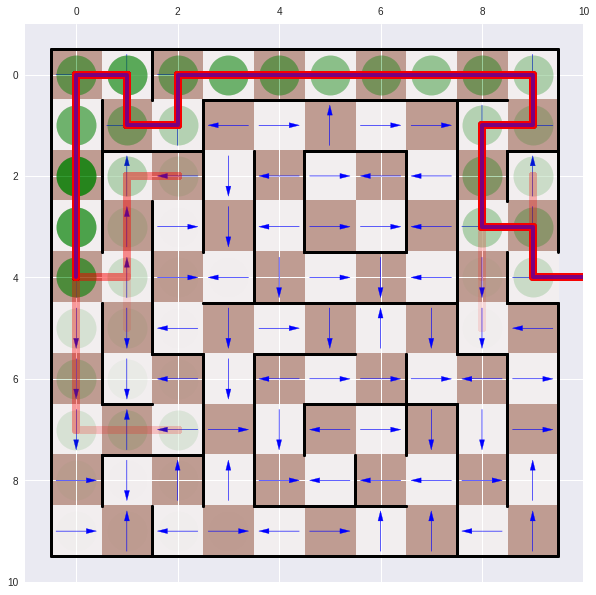

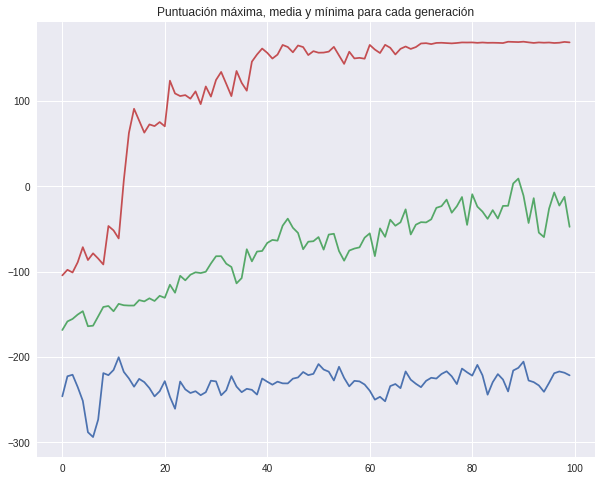

In [ ]:
mapa2 = Map(veneno=1)
avanzar(mapa2)
draw_all(mapa2)

En este caso, se logra encontrar la salida, como sepuede observar en el gráfico la línea roja no es tan estable, pero la puntuación es mas alta.

Sin embargo, abusar de las neurotoxinas letales también puede tener problemas, ¡Quién lo hubiera adivinado!

¡Prueba con la configuración siguiente!

1·2·3·4·5·6·7·8·9·10·11·12·13·14·15·16·17·18·19·20·21·22·23·24·25·26·27·28·29·30·31·32·33·34·35·36·37·38·39·40·41·42·43·44·45·46·47·48·49·50·51·52·53·54·55·56·57·58·59·60·61·62·63·64·65·66·67·68·69·70·71·72·73·74·75·76·77·78·79·80·81·82·83·84·85·86·87·88·89·90·91·92·93·94·95·96·97·98·99·100·

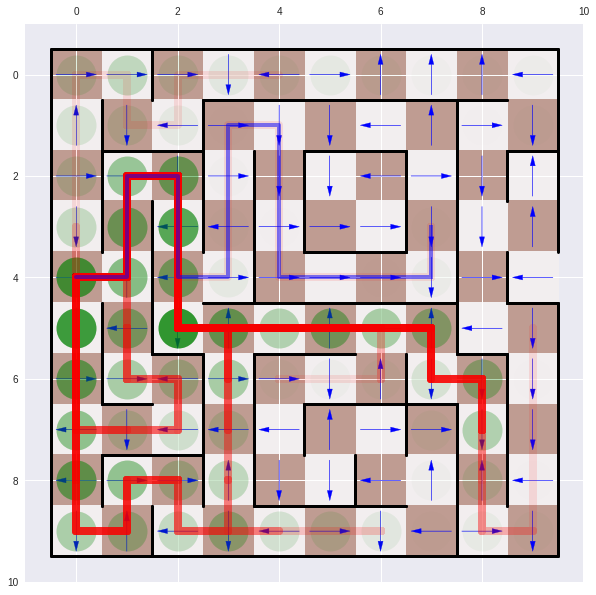

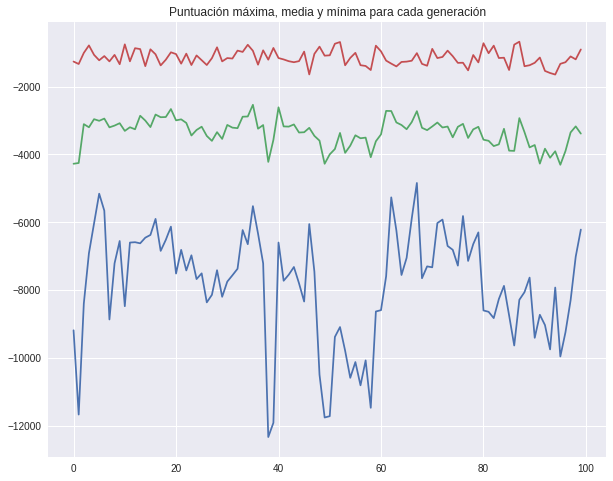

In [ ]:
mapa2 = Map(veneno=100)
avanzar(mapa2)
draw_all(mapa2)

Si te interesa investigar más este efecto, puedes repasar la teoría sobre el dilema exploración-explotación de la parte de teoría.

##Te toca trabajar

¿Qué pasaría si el laberinto cambiara a la vez que se resuelve?

Examina el código. Observa la matriz que describe al laberinto, prueba a cambiar los valores y observa cómo cambia la reoresentación del laberinto. ¿Qué pasaría si la matriz cambiara con el tiempo, por ejemplo, cada 50 o 100 turnos? ¿Podrías hacer que las soluciones posibles se vayan alternando? También puedes probar a cortar los bucles...

Existe un ejercicio muy interesante que se puede hacer basado en esa tarea:

##Efectos de la diversidad genética

Cambia el código para que las posibles salidas del laberinto se alternen con el tiempo. Observa los resultados, comprueba cuánto tarda el algoritmo en encontrar la nueva salida.

Ahora, introduce en la función de mérito un parámetro que premie a individuos cuyo genoma sea diferente al de los demás. Observa la diferencia en el tiempo de adaptación para el laberinto cambiante.

¿Cómo crees que esto se extrapola al mundo biológico? ¿Cómo crees que influye la diversidad genética en la resistencia a plagas y enfermedades de una especie?

Basado en el ejercicio 'Labyrinth' del paquete Evolife del profesor Jean Louis Dessalles.